# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [81]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt 

#from torchmetrics import Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [82]:
#Abgeänderter Code von 2a Trainingsdaten werden nochmal 80/20 gesplittet. Auch hier sind die Räume gleichmäßig repräsentiert

import numpy as np
from sklearn.model_selection import train_test_split
import random

training_path_list = []  # ["./pfad/zu/bildA.png","./pfad/zu/bildB.png",...]
test_path_list = []  # ["./pfad/zu/bildC.png","./pfad/zu/bildD.png",...]

# add all paths to one array
flur_list = []
labor_list = []
buero_list = []
kueche_list = []

for i in range(1,26):
    flur_list.append("./Bilder/Flur/Flur%d.jpg"% i)
    labor_list.append("./Bilder/Labor/Labor%d.jpg"% i)
    buero_list.append("./Bilder/Professorenbuero/Professorenbuero%d.jpg"% i)
    kueche_list.append("./Bilder/Teekueche/Teekueche%d.jpg"% i)

# split the test and training set    
training_flur2, test_flur  = train_test_split(
    flur_list, test_size=0.2, random_state=1
)
training_labor2, test_labor  = train_test_split(
    labor_list, test_size=0.2, random_state=1
)
training_buero2, test_buero  = train_test_split(
    buero_list, test_size=0.2, random_state=1
)
training_kueche2, test_kueche  = train_test_split(
    kueche_list, test_size=0.2, random_state=1
)

#training_path_list = training_flur + training_labor + training_buero + training_kueche
test_path_list = test_flur + test_labor + test_buero + test_kueche # 5 + 5 + 5 + 5

training_flur, val_flur  = train_test_split(
    training_flur2, test_size=0.2, random_state=1
)
training_labor, val_labor  = train_test_split(
    training_labor2, test_size=0.2, random_state=1
)
training_buero, val_buero  = train_test_split(
    training_buero2, test_size=0.2, random_state=1
)
training_kueche, val_kueche  = train_test_split(
    training_kueche2, test_size=0.2, random_state=1
)

training_path_list = training_flur + training_labor + training_buero + training_kueche #16 + 16 + 16 + 16
validation_path_list = val_flur + val_labor + val_buero + val_kueche # 4 + 4 + 4 + 4

#random.shuffle(training_path_list)
#random.shuffle(test_path_list)
#random.shuffle(validation_path_list)

print(validation_path_list)



 

['./Bilder/Flur/Flur5.jpg', './Bilder/Flur/Flur9.jpg', './Bilder/Flur/Flur7.jpg', './Bilder/Flur/Flur17.jpg', './Bilder/Labor/Labor5.jpg', './Bilder/Labor/Labor9.jpg', './Bilder/Labor/Labor7.jpg', './Bilder/Labor/Labor17.jpg', './Bilder/Professorenbuero/Professorenbuero5.jpg', './Bilder/Professorenbuero/Professorenbuero9.jpg', './Bilder/Professorenbuero/Professorenbuero7.jpg', './Bilder/Professorenbuero/Professorenbuero17.jpg', './Bilder/Teekueche/Teekueche5.jpg', './Bilder/Teekueche/Teekueche9.jpg', './Bilder/Teekueche/Teekueche7.jpg', './Bilder/Teekueche/Teekueche17.jpg']


## Teilaufgabe b): CNN definieren und implementieren

In [83]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = 3
        self.hidden_units = 10
        self.output_shape = 4 # Klassen
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, #input_shape,
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.hidden_units,
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.hidden_units,
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.hidden_units,
                  out_channels=self.hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= self.hidden_units*56*56, #Shape nach conv_block_2
                     out_features=self.output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [84]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        #print("Länge list/labels: ",len(img_path_list), len(img_labels))
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        #print("Path: ",img_path)
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [85]:
# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)

        #accuracy_score = Accuracy(task="multiclass", num_classes=4)
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))

        print("F1_Score: ", f1_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        print("Recall: ", recall_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        print("Precision: ", precision_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        cm = confusion_matrix(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

In [86]:
y_train = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])#16+16+16+16
y_test = torch.tensor([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3])#5+5+5+5+5
y_val = torch.tensor([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]) #4+4+4+4
#print(y_train.shape)
#print(y_test.shape)
#print(y_val.shape)

Running on  cpu

Started Training
Epoch 1 from 100
F1_Score:  [0.         0.         0.         0.47619048]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.3125]
F1_Score:  [0.         0.         0.31578947 0.        ]
Recall:  [0. 0. 1. 0.]
Precision:  [0.     0.     0.1875 0.    ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.         0.         0.22222222 0.        ]
Recall:  [0. 0. 1. 0.]
Precision:  [0.    0.    0.125 0.   ]
F1_Score:  [0.         0.31578947 0.         0.        ]
Recall:  [0. 1. 0. 0.]
Precision:  [0.     0.1875 0.     0.    ]
	Train Loss	 1.7274534
	Train Acc.	 0.203125


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.  0.4 0.  0. ]
Recall:  [0. 1. 0. 0.]
Precision:  [0.   0.25 0.   0.  ]
	Val Loss	 1.5538542
	Val Acc.	 0.25
Epoch 2 from 100
F1_Score:  [0.  0.4 0.  0. ]
Recall:  [0. 1. 0. 0.]
Precision:  [0.   0.25 0.   0.  ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.4 0.  0.  0. ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.25 0.   0.   0.  ]
F1_Score:  [0.5 0.4 0.  0. ]
Recall:  [1.   0.25 0.   0.  ]
Precision:  [0.33333333 1.         0.         0.        ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.42105263 0.66666667 0.         0.        ]
Recall:  [1.  0.5 0.  0. ]
Precision:  [0.26666667 1.         0.         0.        ]
	Train Loss	 1.5512434
	Train Acc.	 0.296875
F1_Score:  [0.4 0.  0.  0. ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.25 0.   0.   0.  ]
	Val Loss	 1.4206707
	Val Acc.	 0.25
Epoch 3 from 100


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.22222222 0.         0.         0.        ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.125 0.    0.    0.   ]
F1_Score:  [0.125 0.4   0.    0.   ]
Recall:  [1.   0.25 0.   0.  ]
Precision:  [0.06666667 1.         0.         0.        ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.         0.         0.         0.22222222]
Recall:  [0. 0. 0. 1.]
Precision:  [0.    0.    0.    0.125]
F1_Score:  [0.         0.         0.         0.31578947]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.1875]
	Train Loss	 1.4213603
	Train Acc.	 0.140625


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.  0.  0.  0.4]
Recall:  [0. 0. 0. 1.]
Precision:  [0.   0.   0.   0.25]
	Val Loss	 1.3726834
	Val Acc.	 0.25
Epoch 4 from 100
F1_Score:  [0.         0.         0.         0.54545455]
Recall:  [0. 0. 0. 1.]
Precision:  [0.    0.    0.    0.375]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.         0.         0.         0.47619048]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.3125]
F1_Score:  [0.         0.         0.         0.31578947]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.1875]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.         0.         0.         0.22222222]
Recall:  [0. 0. 0. 1.]
Precision:  [0.    0.    0.    0.125]
	Train Loss	 1.3553281
	Train Acc.	 0.25
F1_Score:  [0.  0.  0.  0.4]
Recall:  [0. 0. 0. 1.]
Precision:  [0.   0.   0.   0.25]
	Val Loss	 1.3594505
	Val Acc.	 0.25
Epoch 5 from 100


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.  0.  0.  0.4]
Recall:  [0. 0. 0. 1.]
Precision:  [0.   0.   0.   0.25]
F1_Score:  [0.         0.         0.         0.47619048]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.3125]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.  0.  0.  0.4]
Recall:  [0. 0. 0. 1.]
Precision:  [0.   0.   0.   0.25]
F1_Score:  [0.         0.         0.         0.31578947]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.1875]
	Train Loss	 1.3081152
	Train Acc.	 0.25


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.         0.4        0.66666667 0.47058824]
Recall:  [0.   0.25 0.5  1.  ]
Precision:  [0.         1.         1.         0.30769231]
	Val Loss	 1.3110037
	Val Acc.	 0.4375
Epoch 6 from 100
F1_Score:  [0.         0.66666667 0.8        0.73684211]
Recall:  [0.         0.5        0.66666667 1.        ]
Precision:  [0.         1.         1.         0.58333333]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.33333333 0.88888889 0.         0.46153846]
Recall:  [0.2 1.  0.  1. ]
Precision:  [1.  0.8 0.  0.3]
F1_Score:  [0.4        0.6        0.66666667 0.5       ]
Recall:  [0.25       0.75       0.6        0.66666667]
Precision:  [1.   0.5  0.75 0.4 ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.57142857 0.8        0.75       0.57142857]
Recall:  [0.4        1.         0.75       0.66666667]
Precision:  [1.         0.66666667 0.75       0.5       ]
	Train Loss	 1.1773307
	Train Acc.	 0.609375
F1_Score:  [0.4        0.72727273 0.28571429 0.66666667]
Recall:  [0.25 1.   0.25 0.75]
Precision:  [1.         0.57142857 0.33333333 0.6       ]
	Val Loss	 1.2303692
	Val Acc.	 0.5625
Epoch 7 from 100
F1_Score:  [0.8        0.66666667 0.6        0.8       ]
Recall:  [0.66666667 1.         0.5        0.66666667]
Precision:  [1.   0.5  0.75 1.  ]
F1_Score:  [1.         0.85714286 0.57142857 0.4       ]
Recall:  [1.         1.         0.66666667 0.25      ]
Precision:  [1.   0.75 0.5  1.  ]
F1_Score:  [0.83333333 0.5        0.33333333 0.33333333]
Recall:  [0.83333333 1.         0.33333333 0.2       ]
Precision:  [0.83333333 0.33333333 0.33333333 1.        ]
F1_Score:  [0.72727273 0.75       0.33333333 0.57142857]
Recall:  [1.   0.75 0.25 0.5 ]
Precision:  [0.57142857 0.75     

C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.75       0.90909091 0.66666667 0.85714286]
Recall:  [1.         0.83333333 0.5        1.        ]
Precision:  [0.6  1.   1.   0.75]
	Train Loss	 0.7304168
	Train Acc.	 0.796875
F1_Score:  [0.66666667 0.5        0.54545455 0.57142857]
Recall:  [0.5  0.5  0.75 0.5 ]
Precision:  [1.         0.5        0.42857143 0.66666667]
	Val Loss	 1.196199
	Val Acc.	 0.5625
Epoch 9 from 100
F1_Score:  [0.88888889 0.66666667 0.57142857 0.57142857]
Recall:  [1.         0.5        0.66666667 0.66666667]
Precision:  [0.8 1.  0.5 0.5]
F1_Score:  [0.8        0.93333333 0.8        0.        ]
Recall:  [0.66666667 1.         1.         0.        ]
Precision:  [1.         0.875      0.66666667 0.        ]
F1_Score:  [0.85714286 0.75       0.71428571 0.        ]
Recall:  [1.         1.         0.71428571 0.        ]
Precision:  [0.75       0.6        0.71428571 0.        ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [1.         0.         0.5        0.66666667]
Recall:  [1.  0.  0.5 0.5]
Precision:  [1.  0.  0.5 1. ]
	Train Loss	 0.6602098
	Train Acc.	 0.71875
F1_Score:  [0.  0.8 0.5 0.6]
Recall:  [0.   1.   0.5  0.75]
Precision:  [0.         0.66666667 0.5        0.5       ]
	Val Loss	 1.7326726
	Val Acc.	 0.5625
Epoch 10 from 100


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.90909091 0.90909091 0.5        0.66666667]
Recall:  [0.83333333 1.         0.5        0.66666667]
Precision:  [1.         0.83333333 0.5        0.66666667]
F1_Score:  [0.4        1.         0.75       0.61538462]
Recall:  [0.25 1.   0.6  1.  ]
Precision:  [1.         1.         1.         0.44444444]
F1_Score:  [0.8        0.66666667 0.66666667 0.8       ]
Recall:  [0.66666667 0.66666667 0.5        1.        ]
Precision:  [1.         0.66666667 1.         0.66666667]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
	Train Loss	 0.41002494
	Train Acc.	 0.8125
F1_Score:  [0.66666667 0.5        0.66666667 0.66666667]
Recall:  [0.5  0.5  0.75 0.75]
Precision:  [1.  0.5 0.6 0.6]
	Val Loss	 1.3631005
	Val Acc.	 0.625
Epoch 11 from 100
F1_Score:  [0.92307692 0.8        0.8        1.        ]
Recall:  [1.         0.66666667 0.8        1.        ]
Precision:  [0.85714286 1.         0.8        1.        ]
F1_Score:  [1.         0.5        0.66666667 1.     

C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
	Train Loss	 0.078370355
	Train Acc.	 1.0
F1_Score:  [0.4        0.66666667 0.66666667 0.66666667]
Recall:  [0.25 0.75 0.75 0.75]
Precision:  [1.  0.6 0.6 0.6]
	Val Loss	 2.0492923
	Val Acc.	 0.625
Epoch 15 from 100
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1.         0.85714286 0.8        1.        ]
Recall:  [1.         1.         0.66666667 1.        ]
Precision:  [1.   0.75 1.   1.  ]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
	Train Loss	 0.066030495
	Train Acc.	 0.984375
F1_Score:  [0.57142857 0.44444444 0.33333333 0.6       ]
Recall:  [0.5  0

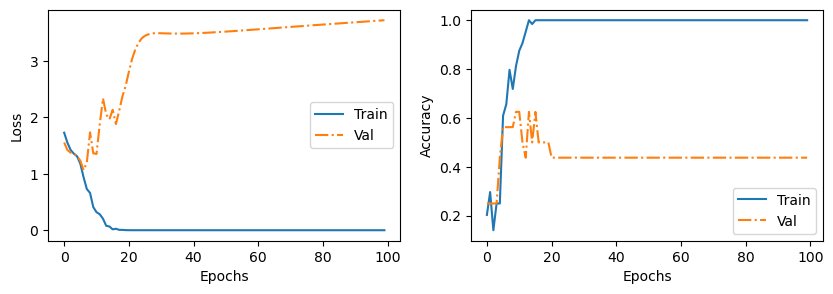

In [87]:
# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()

## Teilaufgabe d): Augmentierung

## Teilaufgabe e): Early Stopping